# Plot Each Organism's Fraction Codon Bias per Amino Acid

For each organism, sum the fraction contribution of each biased codon to its aa's total codon dist. Save in list of tuples.

In [1]:
from matplotlib import pyplot as plt
from codon_dist import flip_trans_table
import os
import glob
import numpy as np

source_org_dir = r'D:\Orthologs\Source_Org_Codon_Dist'

tt_11 = {
        'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
        'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
        'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
        'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
        'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
        'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
        'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
        'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
        'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
        'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
        'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
        'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
        'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
        'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
        'TAC': 'Y', 'TAT': 'Y', 'TAA': '_', 'TAG': 'O',
        'TGC': 'C', 'TGT': 'C', 'TGA': 'U', 'TGG': 'W',
        }

tt_flip = flip_trans_table(tt_11)

org_aa_bias = []

for file in os.listdir(source_org_dir):    
    filename = os.path.join(source_org_dir, file, '')
    
    if os.path.isdir(filename):   # if file is a dir, then it is also a tax_id
        file_list = glob.glob(filename + '*_dist.csv')

        if len(file_list) != 1:
            exit('Too many or no csv files in directory. Ensure exactly one distribution file exists.')

        dist_fh = open(file_list[0], 'r')
        codon_dist = {codon: float(freq) for codon, freq in [line.strip().split(',') for line in dist_fh.readlines()]}
        dist_fh.close()
        
        bias_sums = {}
        for aa, codons in tt_flip.items():
            codon_count = len(codons)
            
            # add up the fraction contribution of each biased codon to its aa's total codon dist.
            percent_bias = sum([codon_dist[codon] for codon in codons if codon_dist[codon] >= (1 / codon_count)])
            
            bias_sums[aa] = percent_bias
            
        
        org_aa_bias.append((file, bias_sums))

#print(org_aa_bias[0:2])

Plot the data (correct xticks)

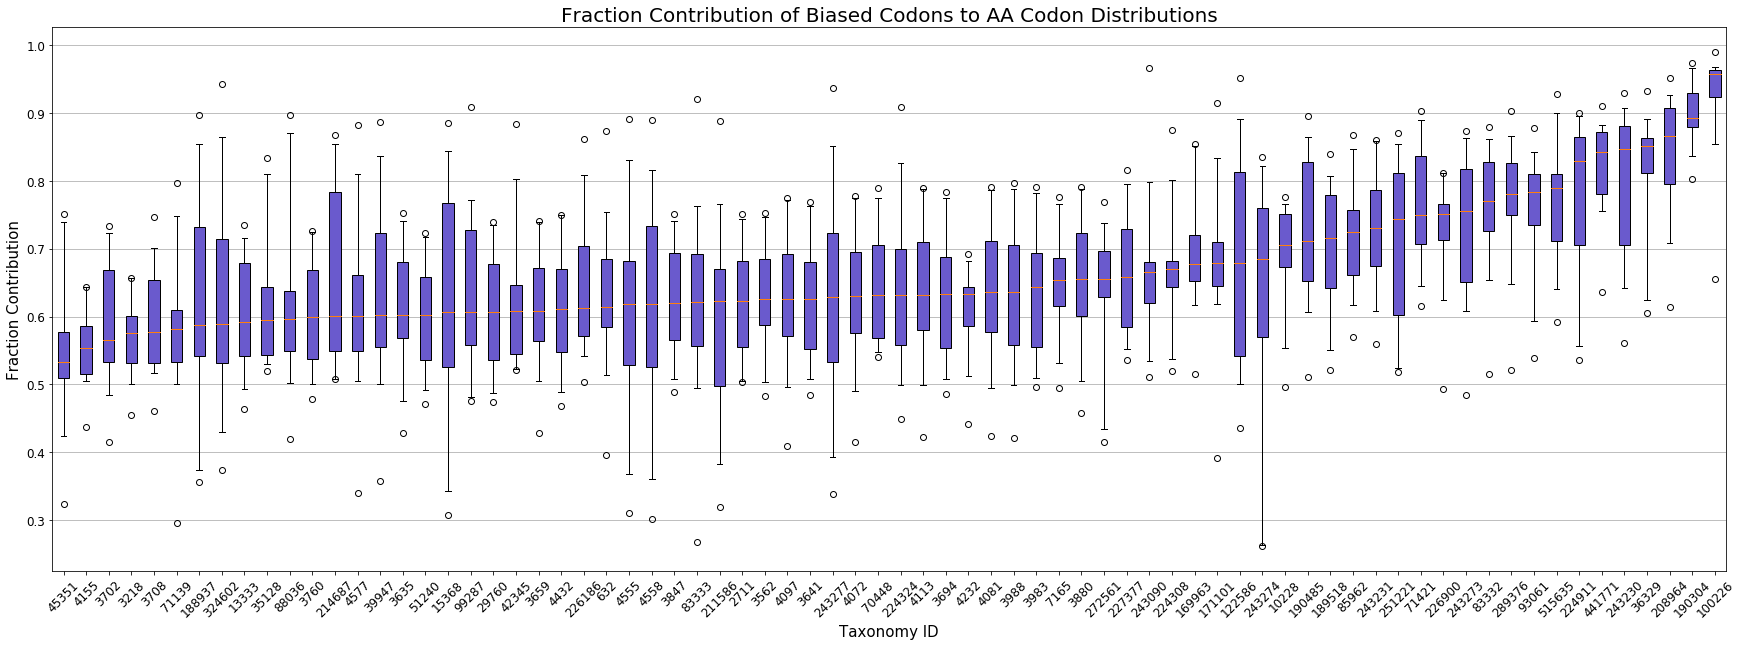

In [10]:
data = [(id, list(dict.values())) for id, dict in org_aa_bias]
data = [(id, [v for v in lst if v != 1.0]) for id, lst in data]
data.sort(key = lambda x: np.median(x[1]))

plt.figure(figsize=(30, 10))
plt.grid(True, axis='y')

boxplot = plt.boxplot([x[1] for x in data], patch_artist=True, whis=[5, 95]) #, showfliers=False)
plt.xticks(range(1, len(data)+1), [x[0] for x in data], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Fraction Contribution', fontsize=15)
plt.xlabel('Taxonomy ID', fontsize=15)
plt.title('Fraction Contribution of Biased Codons to AA Codon Distributions', fontsize=20)

colors = ['slateblue']*len(org_aa_bias)
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.savefig(r'D:\Orthologs\Source_Org_Codon_Dist')


# Plotted by AA

In [7]:
data = {}
for aa in tt_flip:
    data[aa] = []
    for _, dict in org_aa_bias:
        data[aa].append(dict[aa])
        
#print(data)

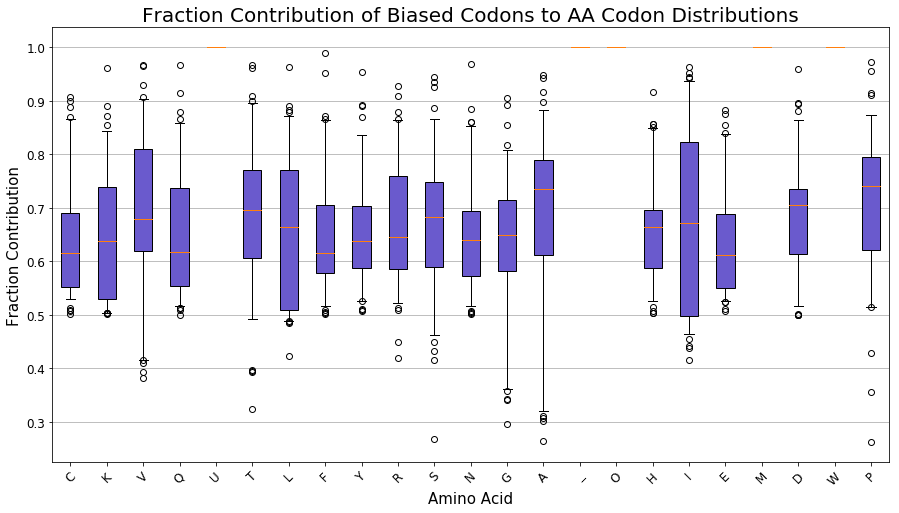

In [8]:
plt.figure(figsize=(15, 8))
plt.grid(True, axis='y')

boxplot = plt.boxplot(list(data.values()), patch_artist=True, whis=[5, 95]) #, showfliers=False)
plt.xticks(range(1, len(data)+1), [aa for aa in data.keys()], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Fraction Contribution', fontsize=15)
plt.xlabel('Amino Acid', fontsize=15)
plt.title('Fraction Contribution of Biased Codons to AA Codon Distributions', fontsize=20)

colors = ['slateblue']*len(data)
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

normalize by min for each aa

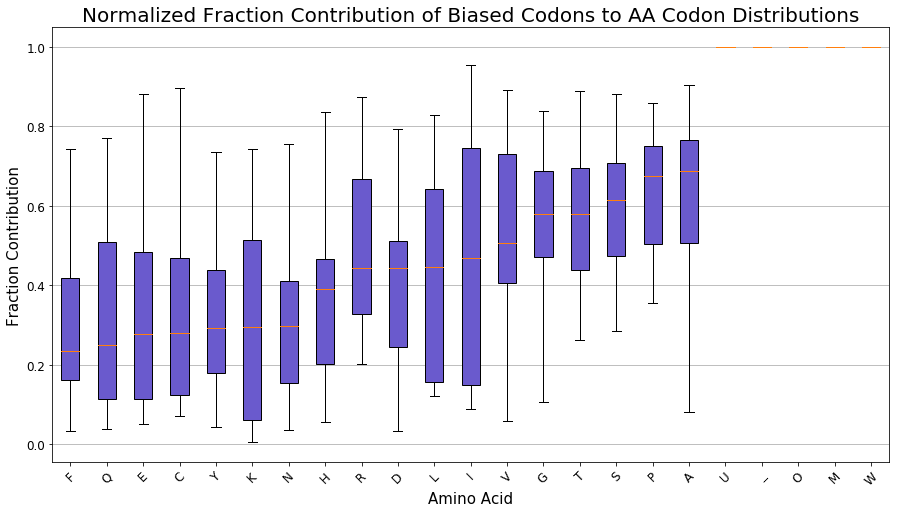

In [9]:
min_normalized_data = {}
for aa, lst in data.items():
    # avoid divide by zero error (occurs when min and max are the same)
    try:
        min_normalized_data[aa] = [(x-min(lst))/(max(lst)-min(lst)) for x in lst]
        
    except ZeroDivisionError:
        min_normalized_data[aa] = lst

# sort dict by median
min_normalized_data = {aa: lst for aa, lst in sorted(min_normalized_data.items(), key = lambda item: np.median(item[1]))}
        
plt.figure(figsize=(15, 8))
plt.grid(True, axis='y')

boxplot = plt.boxplot(list(min_normalized_data.values()), patch_artist=True, whis=[5, 95], showfliers=False)
plt.xticks(range(1, len(min_normalized_data)+1), [aa for aa in min_normalized_data.keys()], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Fraction Contribution', fontsize=15)
plt.xlabel('Amino Acid', fontsize=15)
plt.title('Normalized Fraction Contribution of Biased Codons to AA Codon Distributions', fontsize=20)

colors = ['slateblue']*len(min_normalized_data)
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)